# Trabajo Práctico 1
## Métricas custom para reducción de falsos positivos en clasificación binaria fraude

**Mark Albrand - 21004**

### Función a optimizar

*Detectar fraudes en regiones con alta incidencia histórica*


In [1]:
# Variables creadas durante el feature engineering

feature_engineering = [
    "fraud_rate_by_zip",
    "fraud_rate_by_city",
    "fraud_rate_by_state",
    "city_fraud_count",

    "monthly_zip_fraud_rate",
    "rolling_fraud_rate_by_zip",

    "region_density",
]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# dataset con las nuevas features
dataset = pd.read_csv("data/dataset.csv", index_col=0)

In [4]:
for c in dataset.columns:
    print(c)

cc_num
merchant
category
amt
first
last
gender
street
city
state
zip
lat
long
city_pop
job
dob
trans_num
unix_time
merch_lat
merch_long
is_fraud
amt_month
amt_year
amt_month_shopping_net_spend
count_month_shopping_net
first_time_at_merchant
dist_between_client_and_merch
trans_month
trans_day
hour
year
times_shopped_at_merchant
times_shopped_at_merchant_year
times_shopped_at_merchant_month
times_shopped_at_merchant_day
fraud_rate_by_zip
fraud_rate_by_city
fraud_rate_by_state
city_fraud_count
monthly_zip_fraud_rate
rolling_fraud_rate_by_zip
lat_bin
long_bin
region_density


## Modelo Base

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
drop_cols = [
    'cc_num',
    'first',
    'last',
    'street',
    'trans_num',
    'dob',
    'unix_time'
]

In [7]:
dataset = dataset.drop(columns=drop_cols, errors='ignore')

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
# usar LabelEncoder para convertir las variables categóricas a numéricas
label_encoder = LabelEncoder()

In [10]:
categorical_cols = dataset.select_dtypes(include=['object']).columns

for col in categorical_cols:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [11]:
dataset["first_time_at_merchant"] = dataset["first_time_at_merchant"].astype(int)  # Booleano -> int

In [12]:
X = dataset.drop(columns=["is_fraud"])
y = dataset["is_fraud"]

In [13]:
X.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,times_shopped_at_merchant_day,fraud_rate_by_zip,fraud_rate_by_city,fraud_rate_by_state,city_fraud_count,monthly_zip_fraud_rate,rolling_fraud_rate_by_zip,lat_bin,long_bin,region_density
1514,398,7,48.43,0,753,19,1257,42.1001,-73.3611,2121,...,2,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308
2491,351,8,1.58,0,753,19,1257,42.1001,-73.3611,2121,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308
4762,174,11,6.10,0,753,19,1257,42.1001,-73.3611,2121,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308
6043,492,6,8.42,0,753,19,1257,42.1001,-73.3611,2121,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308
6499,273,2,31.53,0,753,19,1257,42.1001,-73.3611,2121,...,3,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308


In [14]:
y.head()

1514    0
2491    0
4762    0
6043    0
6499    0
Name: is_fraud, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [16]:
from lightgbm import LGBMClassifier

In [17]:
model = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [18]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7238, number of negative: 1382057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5130
[LightGBM] [Info] Number of data points in the train set: 1389295, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', n_jobs=-1, objective='binary',
               random_state=42)

### Evaluaciones del modelo inicial

In [19]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report

In [20]:
# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [21]:
# Métricas
roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

In [22]:
print("AUC-ROC:", roc)
print("F1-Score:", f1)
print(classification_report(y_test, y_pred, digits=4))

AUC-ROC: 0.9995155187215816
F1-Score: 0.9325058184639256
              precision    recall  f1-score   support

           0     1.0000    0.9993    0.9996    460686
           1     0.8764    0.9963    0.9325      2413

    accuracy                         0.9992    463099
   macro avg     0.9382    0.9978    0.9661    463099
weighted avg     0.9993    0.9992    0.9993    463099



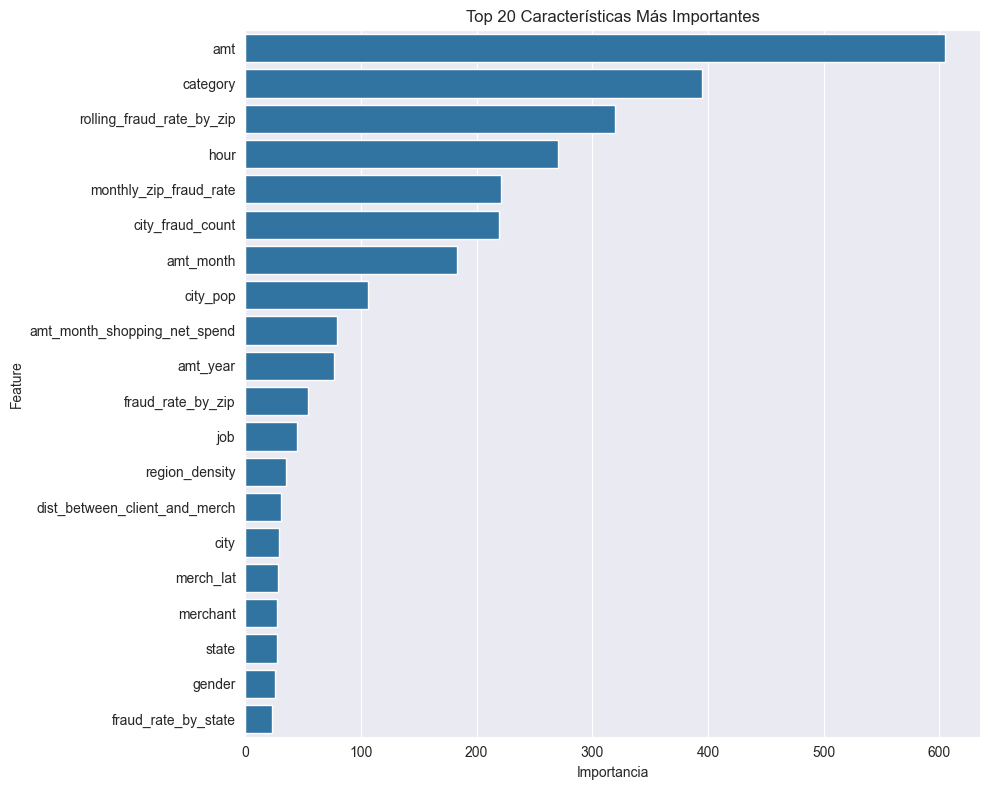

In [23]:
feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index)
plt.title("Top 20 Características Más Importantes")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()